# EM algorithm test 3

In [1]:
import matplotlib.pyplot as plt
import birdepy as bd
import numpy as np

import sys
sys.path.append('../src/')

from simulate_gillespie import gillespie_linear, discretize_sequence

# Simple linear BDP

Setup for linear_BDP_test
N = 100, I0 = 5, time_max = 50.0
beta = 0.8, mu = 0.55
R_0 = 1.45
break: time >= time_max
[(5, 9, np.float64(1.0)), (9, 10, np.float64(1.0)), (10, 17, np.float64(1.0)), (17, 18, np.float64(1.0)), (18, 26, np.float64(1.0))]


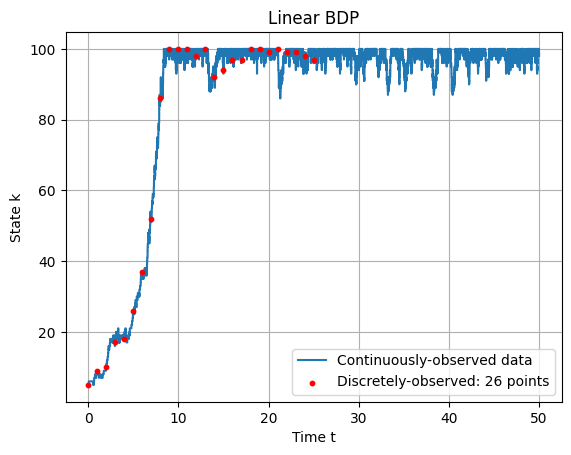

In [2]:
## --- Setup --- ##
test_name = "linear_BDP_test"

N = 100
I0 = 5

time_max = 50.0

# linear BDP rates, $: R_0 > 1
beta = 0.8 # birth rate
mu = 0.55   # death rate


theta_true = (beta, mu)

print(f"Setup for {test_name}")
print(f"N = {N}, I0 = {I0}, time_max = {time_max:.1f}")
print(f"beta = {beta}, mu = {mu}")
print(f"R_0 = {beta / mu:.2f}")

# generate continuously observed data
# discretize it
# plot both

# choose 25 intervals that is 26 observation points
# with dt = (25 - 0)/25 = 1
t_obs_start = 0.0
t_obs_end = 25.0
num_intervals = 25

X_times, X_states = gillespie_linear(N, theta_true, I0, time_max)
len(X_times) # number of events

Y_obs_sequence = discretize_sequence((X_times, X_states), t_obs_start, t_obs_end, num_intervals)
print(Y_obs_sequence[:5])

# plot data
plt.figure()

plt.step(X_times, X_states, where='post', 
         label='Continuously-observed data')

observation_times = np.linspace(t_obs_start, t_obs_end, num_intervals + 1)

# state at t_obs_start
observed_states_at_times = [Y_obs_sequence[0][0]]

# states at t_obs_start + dt, + 2dt, ..., t_obs_end
observed_states_at_times.extend([interval[1] for interval in Y_obs_sequence])

plt.scatter(observation_times, observed_states_at_times,
            color='red', marker='o', s=10, zorder=2,
            label=f'Discretely-observed: {num_intervals + 1} points')

plt.title("Linear BDP")
plt.xlabel("Time t")
plt.ylabel("State k")

plt.legend()
plt.grid(True)
plt.show()

## Estimate

In [ ]:
dt = Y_obs_sequence[0][2] # step size, interval duration
observed_times = np.linspace(t_obs_start, t_obs_end + num_intervals * dt, num_intervals + 1)

observed_states = [Y_obs_sequence[0][0]]
observed_states.extend([interval[1] for interval in Y_obs_sequence])

t_data_input = list(observed_times)
p_data_input = list(observed_states)

# set bounds (0, 5]
p_bounds = [[1e-9, 5.0], [1e-9, 5.0]]

# 25 intervals, means 25 sets of E-step calculations
# E[U | Y], E[D | Y], E[T_part | Y] for each (a, b, dt) in Y

# accelerator='none'

# switching to matrix exponential technique='expm':

p0_guess = [0.6, 0.6]
# run EM until 
# |\theta^{(k + 1)} - \theta^{(k)}| < tol 
# or max_iter is reached
est_em_expm = bd.estimate(
    t_data=t_data_input,
    p_data=p_data_input,
    p0=p0_guess,
    p_bounds=p_bounds,
    framework='em',
    model='linear',
    technique='expm',
    accelerator='Lange', # let's use Lange acceleration
    max_it=100, # max iter
    i_tol=1e-6, # tol
    # laplace_method='cme-talbot', # Default ILT method
    # lentz_eps=1e-6, # Lentz algorithm tolerance
    se_type='asymptotic', # std errors using Hessian
    display=True # show progress
)

/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Iteration  1  estimate is:  [0.61161439 0.58713335]
Iteration  2  estimate is:  [0.34594476 0.32032402]
Iteration  3  estimate is:  [0.34535603 0.32087015]
Iteration  4  estimate is:  [0.34535603 0.32087015]


In [5]:
theta_hat = est_em_expm.p
beta_hat = theta_hat[0]
mu_hat = theta_hat[1]

In [6]:
theta_se = est_em_expm.se
beta_se = theta_se[0]
mu_se = theta_se[1]

In [18]:
print(f"beta \t beta_hat \t beta_se")
print(f"{beta:^.4f} \t {beta_hat:^.4f} \t {beta_se:^.4f}\n")

print(f"mu \t mu_hat \t mu_se")
print(f"{mu:^.4f} \t {mu_hat:^.4f} \t {mu_se:^.4f}")

beta 	 beta_hat 	 beta_se
0.8000 	 0.3454 	 0.0954

mu 	 mu_hat 	 mu_se
0.5500 	 0.3209 	 0.0954
